In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from common.baseclasses import AWA
from importlib import reload
from common import numerical_recipes as numrec
from common.numerical_recipes import QuickConvolver,smooth
import EigenProbe as EP
TM=EP #legacy naming support
S=TM.S
from NearFieldOptics import Materials as M

import warnings
warnings.filterwarnings('ignore')

from BasovPlasmons import plasmon_modeling as PM
import mshr


Bad key text.latex.unicode in file /Users/alexandersmcleod/.matplotlib/matplotlibrc, line 167 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution
/Users/alexandersmcleod/tools/python/common/baseclasses.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  try: result=ndarray_operator(self,*args,**kwargs)
/Users/alexandersmcleod/tools/python/common/baseclasses.py:482: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `

# Build elements of simulation

In [2]:
#--- Number of basis functions to use
Nq=2000 #This is biiiig but produces good results; reduce if CPU has limited resources

#--- Overall size
N=300
Lx=Ly=400 #We will deal in units of tip radius, so this will be a 8 micron (or so) view

## Conductive 2D material domain - an "antenna"

Running fenics solver...
	Time elapsed: 9.387218236923218
Interpolating from fenics mesh...
Processing time per function: 0.030424131949742635
	Time elapsed: 19.362612009048462


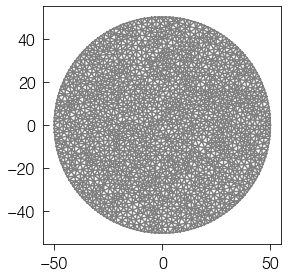

In [3]:
#--- Build 2D domains

Rx=Ry=50
geometry1=mshr.Circle(PM.Point(0,0),Rx)
mesh1 = mshr.generate_mesh(geometry1, 30, "cgal")

plt.figure()
PM.plot(mesh1)

#--- Run fenics
print('Running fenics solver...')
T=S.Timer()
Nfenics1=600
Nfenics2=2000
output1=PM.helmholtz(mesh1, eigenvalue=0, number_extracted = Nfenics1, sigma_2=1.0, to_plot=False,
                   charge_distribution = lambda x,y: 1)
print(T())

#--- Build operators

print('Interpolating from fenics mesh...')
T=S.Timer()
eigpairs1=PM.interpolate_fenics_eigpairs(output1,xlims=[-Lx/2,Lx/2],ylims=[-Ly/2,Ly/2],Nx=N,Neig=Nfenics1)
Antenna=S.SpectralOperator(eigpairs1)
print(T())

## Non-default PML

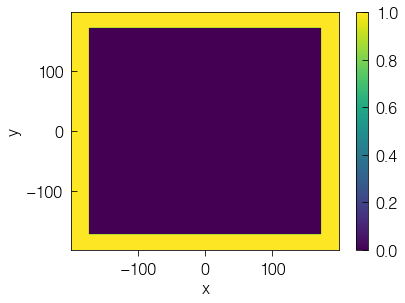

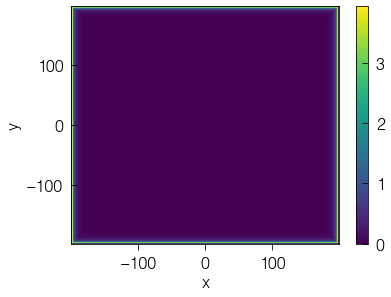

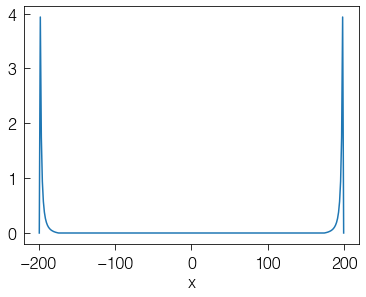

In [4]:
PML=TM.DefaultPML(size=(Lx,Ly),Nx=N,Nfwhm=1,Nwidth=20,k=2,Nbuf=1)
plt.figure()
PML.get_PML_domain().plot()
plt.figure()
PML.get_PML_profile().plot()
plt.figure()
PML.get_PML_profile().cslice[:,0].plot()

## Nontrivial substrate - layered hBN

Generating eigenpairs on x,y=[-200.0:+200.0:300],[-200.0:+200.0:300]
	Time elapsed: 3.4349050521850586


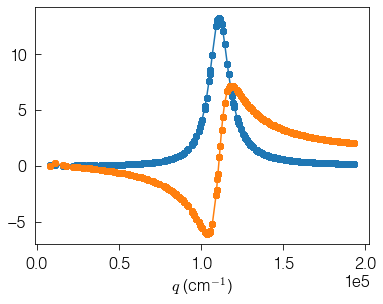

In [5]:
freq=1460
layers=M.LayeredMediaTM((M.BN_Caldwell,40e-7),exit=M.SiO2_300nm)

Substrate=TM.SubstrateFromLayers(layers,length_unit=20e-7,freq=freq,\
                                 Lx=Lx,Nx=N,Ly=Ly,\
                                 Nqmax=Nq)

plt.figure()
np.imag(Substrate.rp).plot(marker='o')
np.real(Substrate.rp).plot(marker='o')

# Build the photonic system: antenna + substrate

In [6]:
Q=1
PS=TM.Photonic2DSystem(Substrate,[Antenna],PML=PML,
                       lambdap=200,sigmas2D=[1-1j/Q],PML_amplitude=1,\
                       basis=None,Nbasis=Nq)

X,Y=PS.XY

Constructing augmented basis with 2D materials...
Finding augmented basis by QR decomposition...
	Removed 0 redundant vectors.
	Time elapsed: 63.89128589630127
Building Laplacian operator in augmented basis...
Building 2500x1900 inner product matrix...
	Time elapsed: 3.9322829246520996
Building 2500x600 inner product matrix...
	Time elapsed: 1.4742279052734375
Diagonalizing new Hermitian operator of size (2500, 2500)...
	Time elapsed: 11.92237901687622
	Time elapsed: 20.677370309829712
Filtered 52 eigenpairs.
Filtered 447 eigenpairs.
Size of composite laplacian: 2002
Projecting operator 1 onto basis...
Building 2002x1900 inner product matrix...
	Time elapsed: 3.1895439624786377
Projecting operator 2 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 22.574883937835693
Building 2002x2002 inner product matrix...
	Time elapsed: 14.762765884399414
Projecting operator 3 onto basis...
Building 2002x2002 inner product matrix...
	Time elapsed: 3.942244052886963
Projecting operator 4

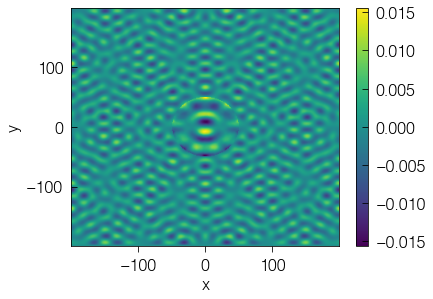

In [7]:
#--- See that basis functions in the composite basis look reasonable
i=1500
plt.figure()
PS.functions[i].plot()

# Compute some responses

## Local excitation from tip

In [8]:
#--- This is just a dipole, emulating the field from a tip

def excitation(Rx,Ry,a=1):
    
    direction=[0,1]
    z=5*a #This gives a qpeak=1/(2*z)=1/(10a) (Jiang & Fogler) and lambda_peak=2*pi*10a
    r=np.sqrt(Rx**2+Ry**2+z**2)
    rho=np.sqrt(Rx**2+Ry**2)
    rhat_rho=rho/r
    rhat_z=z/r

    exc=(direction[0]*rhat_rho+direction[1]*rhat_z)/r**2
    
    return AWA(exc,adopt_axes_from=PS.AWA)

In [9]:
PS.set_PML_amplitude(3e-2)
PS.set_LambdaP(1e3) # An ideal metal antenna

x0=60
refl=PS(excitation(X-x0,Y))

ValueError: 'BWR2' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

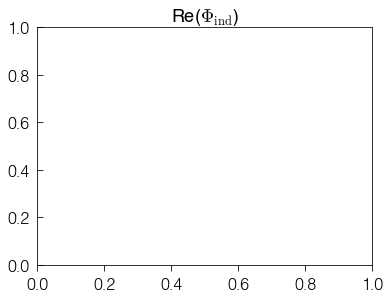

In [10]:
plt.figure()
plt.title('Re($\Phi_\mathrm{ind}$)')
np.real(-refl).plot(cmap='BWR2')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-.01,.01)

plt.figure()
plt.title('Im($\Phi_\mathrm{ind}$)')
np.imag(-refl).plot(cmap='BWR2')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-.01,.01)

plt.figure()
plt.title('Abs($\Phi_\mathrm{ind}$)')
np.abs(refl).plot()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(0,.005)

### Linescan while varying PML strength

In [ ]:
excs=[excitation(X-x0,Y) for x0 in PS.xy[0]]

pml_amps=[0]+list(np.logspace(-3,0,3))
colors=zip(np.linspace(0,1,len(pml_amps)),\
           [0]*len(pml_amps),\
            np.linspace(1,0,len(pml_amps)))

plt.figure()
for i,pml_amp in enumerate(pml_amps):
    print('Setting pml strength:',pml_amp)
    PS.set_PML_amplitude(pml_amp)
    linescan=AWA(PS.R(excs,exclude_PML=True),axes=[PS.xy[0]],axis_names=['x'])
    np.abs(linescan).plot(color=next(colors))

In [ ]:
plt.figure()
plt.title('PML profile')
plt.plot(PML.sigma.squeeze()[150].imag)
plt.ylabel(r'Im $\sigma$')
plt.tight_layout()
plt.xlim(0,50)

## Far-field excitation from plane wave

In [ ]:
WL_FF=Lx/3
PW=np.exp(2*np.pi*1j*X/WL_FF+np.pi/4*1j)
plt.figure()
AWA(PW,adopt_axes_from=PS.AWA).real.plot(cmap='BWR2')
plt.title('Re($\Phi_\mathrm{ext}$)')
plt.tight_layout()

In [ ]:
#--- Compute response
PS.set_PML_amplitude(0) #We're exciting inside PML region, so turn it off
refl_FF=PS(PW)
refl_FF_subs=Substrate(PW) #Substrate response separately so we can subtract it

### Plot Induced field

In [ ]:
#--- Plot the total potential
plt.figure()
np.real(refl_FF_subs-refl_FF).plot(cmap='BWR2')
plt.title('Re($\Phi_\mathrm{ant}-\Phi_\mathrm{hBN}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-1,1)

plt.figure()
np.imag(refl_FF_subs-refl_FF).plot(cmap='BWR2')
plt.title('Im($\Phi_\mathrm{ant}-\Phi_\mathrm{hBN}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-1,1)

plt.figure()
np.abs(refl_FF_subs-refl_FF).plot(cmap='viridis')
plt.title('Abs($\Phi_\mathrm{ant}-\Phi_\mathrm{hBN}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(0,1)

In [ ]:
plt.figure()
plt.title(r'$\Phi_\mathrm{ant}$')
np.real(-refl_FF).cslice[:,0].plot(color='r',label='Re')
np.imag(-refl_FF).cslice[:,0].plot(color='b',label='Im')
plt.xlim(-170,170)
plt.ylim(-1,1)
plt.axhline(0,color='k',ls='--')
plt.tight_layout()
plt.legend()

### Plot Total field

In [ ]:
#--- Plot the total potential
plt.figure()
np.real(PW-refl_FF).plot(cmap='BWR2')
plt.title('Re($\Phi_\mathrm{ant}+\Phi_\mathrm{ext}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-1,1)

plt.figure()
np.imag(PW-refl_FF).plot(cmap='BWR2')
plt.title('Im($\Phi_\mathrm{ant}+\Phi_\mathrm{ext}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(-1,1)

plt.figure()
np.abs(PW-refl_FF).plot(cmap='viridis')
plt.title('Abs($\Phi_\mathrm{ant}+\Phi_\mathrm{ext}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(0,1.5)

In [ ]:
#--- Re-plot with actual axes in actual length units
Vtot=PW-refl_FF
Vtot=AWA(Vtot,axes=[ax*20e-7/1e-4 for ax in Vtot.axes],axis_names=['x (microns)','y (microns)'])

plt.figure()
np.abs(Vtot).plot(cmap='viridis')
plt.title('Abs($\Phi_\mathrm{ant}+\Phi_\mathrm{ext}$)')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.clim(0,1.5)